In [45]:
import sys
import os

package_path: str = ".."
if package_path not in sys.path:
    sys.path.append(package_path)

In [46]:
%reload_ext autoreload
%autoreload 2

In [47]:
from src.integrator.loader import PalXFELLoader
from src.config import load_config
from src.filesystem import get_run_scan_dir


config = load_config()
file = get_run_scan_dir(config.path.load_dir, 168, 1, sub_path="p0001.h5")
loader = PalXFELLoader(file)
data = loader.get_data()
images = data["poff"]
print(images.shape)

2025-08-06 13:20:43.874 | INFO     | src.integrator.loader:__init__:76 - Loaded 300 images and 300 qbpm data.
2025-08-06 13:20:43.877 | INFO     | src.integrator.loader:__init__:77 - Pump state distribution: 150 on, 150 off.


(150, 514, 1030)


In [48]:
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from roi_rectangle import RoiRectangle

matplotlib.rcParams['font.family'] = 'Malgun Gothic'

plt.rcParams['axes.unicode_minus'] = False

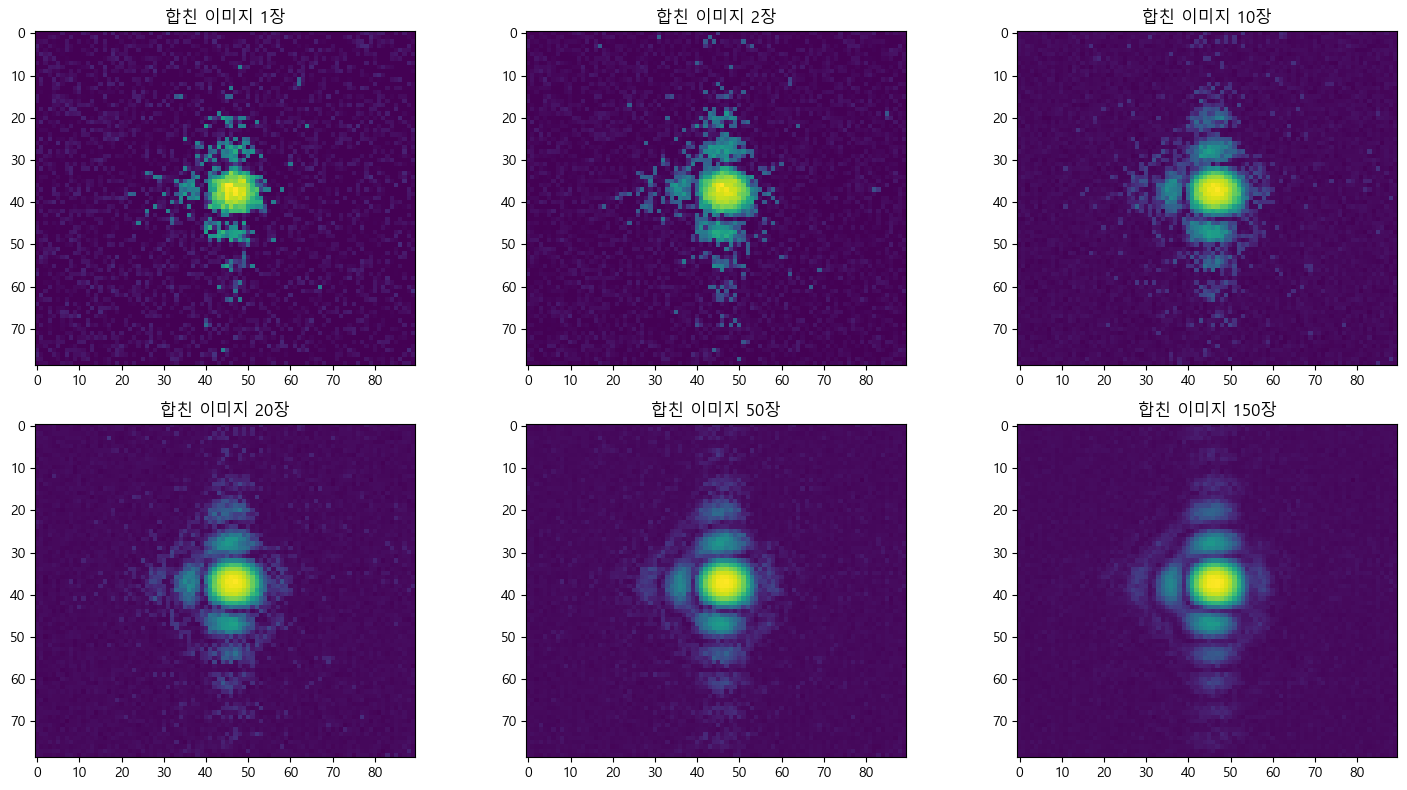

In [63]:
rect = RoiRectangle(x1=340, y1=92, x2=430, y2=171)
num: int = 150
summed_image = rect.slice(np.sum(images[:num], axis=0))
fig, axs = plt.subplots(2, 3, figsize=(15, 8))
for ax, num in zip(axs.ravel(), [1, 2, 10, 20, 50, 150]):
    summed_image = rect.slice(np.sum(images[:num], axis=0)) / num
    ax.set_title(f"합친 이미지 {num}장")
    ax.imshow(np.log1p(summed_image))

fig.tight_layout()
fig.savefig('high_res_plot.png', dpi=300)

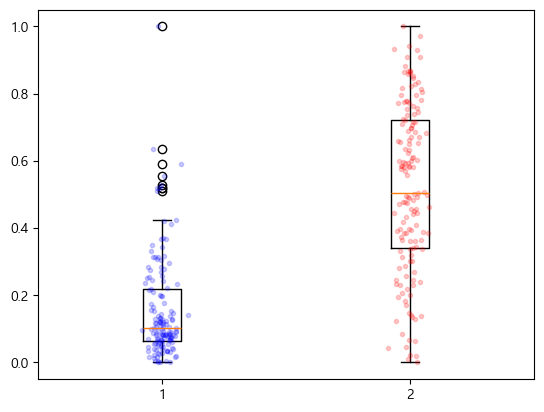

In [94]:
from src.mathematics import min_max_scale


roi_rect = RoiRectangle(x1=379, y1=123, x2=394, y2=136)
intensities = images.sum(axis=(1, 2))

intensities_norm = min_max_scale(intensities)
qbpms_norm = min_max_scale(qbpms)

fig, ax = plt.subplots(1, 1)
ax.boxplot([intensities_norm, qbpms_norm])

x = np.random.normal(1, 0.03, size=len(intensities))
ax.plot(x, intensities_norm, 'b.', alpha=0.2)
x = np.random.normal(2, 0.03, size=len(qbpms))
ax.plot(x, qbpms_norm, 'r.', alpha=0.2)

(26, 514, 1030)


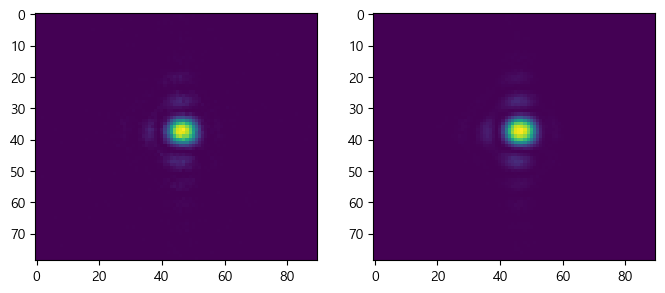

In [95]:
from src.preprocessor.image_qbpm_preprocessor import (
    ImagesQbpmProcessor,
    make_qbpm_roi_normalizer,
    make_thresholder,
    # subtract_dark_background,
)
from src.functional import compose


roi_rect = RoiRectangle(x1=379, y1=123, x2=394, y2=136)
filter_and_normalize_by_qbpm = make_qbpm_roi_normalizer(roi_rect)
threshold4 = make_thresholder(4)
# compose make a function that exicuted from right to left
preprocessor = compose(
    # threshold4,
    filter_and_normalize_by_qbpm,
    # subtract_dark_background
)

result_images, _ = preprocessor([images, qbpms])
print(result_images.shape)
result_image = rect.slice(np.sum(result_images, axis=0))
result_image = min_max_scale(result_image)
summed_image = min_max_scale(summed_image)

fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].imshow(np.log1p(result_image))
axs[1].imshow(np.log1p(summed_image))